#### Filtering US dataframe into WY

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools
from itertools import combinations
from scipy import spatial
import pickle as pickle
import gudhi
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# imoporting SVI data for the entire US(county level) 
us_svi = gpd.read_file('../data/processed data/SVI 2018 with HepVu/SVI2018_US_county_with_opioid_indicators.shp')

In [3]:
# include only the Wyoming(county level)
filtered_svi_df = us_svi[us_svi['ST_ABBR'].isin(['TN'])]

In [4]:
# reset index
filtered_svi_df.reset_index(drop=True, inplace=True)

In [5]:
filtered_svi_df

,ST,STATE,ST_ABBR,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,...,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,GEO ID,NOD_Rate,geometry
0,47,TENNESSEE,TN,Anderson,47001,"Anderson County, Tennessee",337.203175,75775,0,34932,...,0,0,6889,660,9.2,0.9,77087,47001,38.3,"POLYGON ((-84.44988 36.15105, -84.44823 36.152..."
1,47,TENNESSEE,TN,Bedford,47003,"Bedford County, Tennessee",473.638959,47558,0,18928,...,0,0,5321,655,11.3,1.4,44134,47003,21.8,"POLYGON ((-86.66330 35.47122, -86.66292 35.474..."
2,47,TENNESSEE,TN,Blount,47009,"Blount County, Tennessee",558.816658,128443,0,57296,...,0,0,11220,1033,8.8,0.8,117962,47009,33.4,"POLYGON ((-84.18832 35.61055, -84.18540 35.611..."
3,47,TENNESSEE,TN,Bradley,47011,"Bradley County, Tennessee",328.761662,104557,0,43377,...,0,0,12260,1000,11.8,1.0,100691,47011,26.6,"POLYGON ((-85.02664 35.13617, -85.02551 35.139..."
4,47,TENNESSEE,TN,Cannon,47015,"Cannon County, Tennessee",265.635253,13976,0,6131,...,0,0,1395,292,10.1,2.1,10145,47015,31.8,"POLYGON ((-86.20812 35.71560, -86.20658 35.716..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,47,TENNESSEE,TN,Morgan,47129,"Morgan County, Tennessee",522.179665,21596,0,8988,...,2,4,2072,378,11.0,2.0,16795,47129,30.0,"POLYGON ((-84.91415 36.20829, -84.91275 36.210..."
91,47,TENNESSEE,TN,Bledsoe,47007,"Bledsoe County, Tennessee",406.424786,14602,0,5783,...,2,5,1741,372,13.0,2.8,12316,47007,23.1,"POLYGON ((-85.43618 35.54216, -85.43395 35.543..."
92,47,TENNESSEE,TN,Grundy,47061,"Grundy County, Tennessee",360.444829,13331,0,6451,...,1,5,2232,376,17.0,2.9,10250,47061,32.9,"POLYGON ((-85.91196 35.29054, -85.90982 35.294..."
93,47,TENNESSEE,TN,Lauderdale,47097,"Lauderdale County, Tennessee",471.966905,26297,0,11303,...,2,6,2423,353,10.3,1.5,21808,47097,18.0,"POLYGON ((-89.95834 35.72656, -89.95376 35.731..."


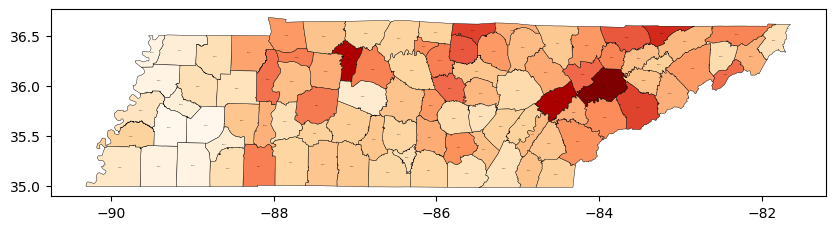

In [6]:
# Plot the data for the Washington DC, Virginia, Maryland, and West Virginia(county level)
ax = filtered_svi_df.plot(figsize=(10, 10), column="NOD_Rate", legend=False, cmap='OrRd', edgecolor='black',linewidth=0.3)

for idx, row in filtered_svi_df.iterrows():
    centroid = row.geometry.centroid
    county_name = row.FIPS
    ax.annotate(text=county_name, xy=(centroid.x, centroid.y), ha='center', fontsize=0.5)

# Display the plot
plt.show()

#### Adding the percentiles

In [7]:
filtered_svi_df['percentile'] = pd.qcut(filtered_svi_df['NOD_Rate'], q=[0, 0.1, 0.3, 0.5, 0.7, 0.9, 1], labels=['<10%', '10%-30%', '30%-50%', '50%-70%', '70%-90%', '>90%'])

/Users/h6x/anaconda3/envs/TDA/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


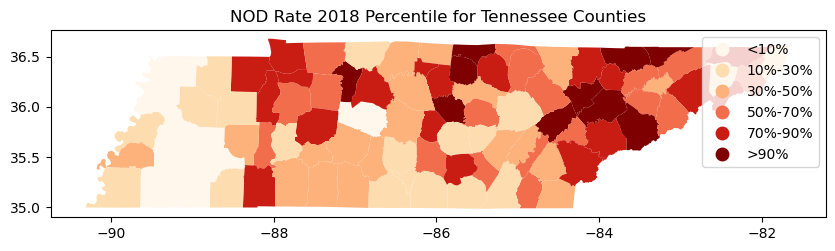

In [9]:
# Plot the percentiles for the overdose data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

filtered_svi_df.plot(column='percentile', ax=ax, legend=True, cmap='OrRd', linewidth=0.3)

plt.title('NOD Rate 2018 Percentile for Tennessee Counties')
plt.show()

#### Saving dataframe to a shapefile

In [10]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(filtered_svi_df, geometry='geometry')

In [12]:
gdf['percentile'] = gdf['percentile'].astype(str)

In [13]:

# Save the GeoDataFrame to a Shapefile
gdf.to_file("./data/processed data/SVI2018 TN counties with death rate HepVu/SVI2018_TN_counties_with_death_rate_HepVu.shp", driver='ESRI Shapefile')